
Classification Report

              precision    recall  f1-score   support

           0       0.91      0.68      0.78      1035
           1       0.48      0.82      0.61       374

    accuracy                           0.72      1409
   macro avg       0.70      0.75      0.69      1409
weighted avg       0.80      0.72      0.73      1409

ROC-AUC: 0.8347


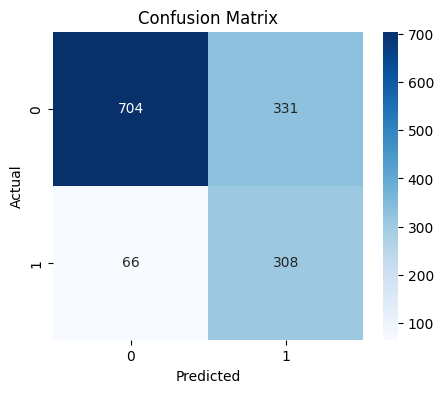

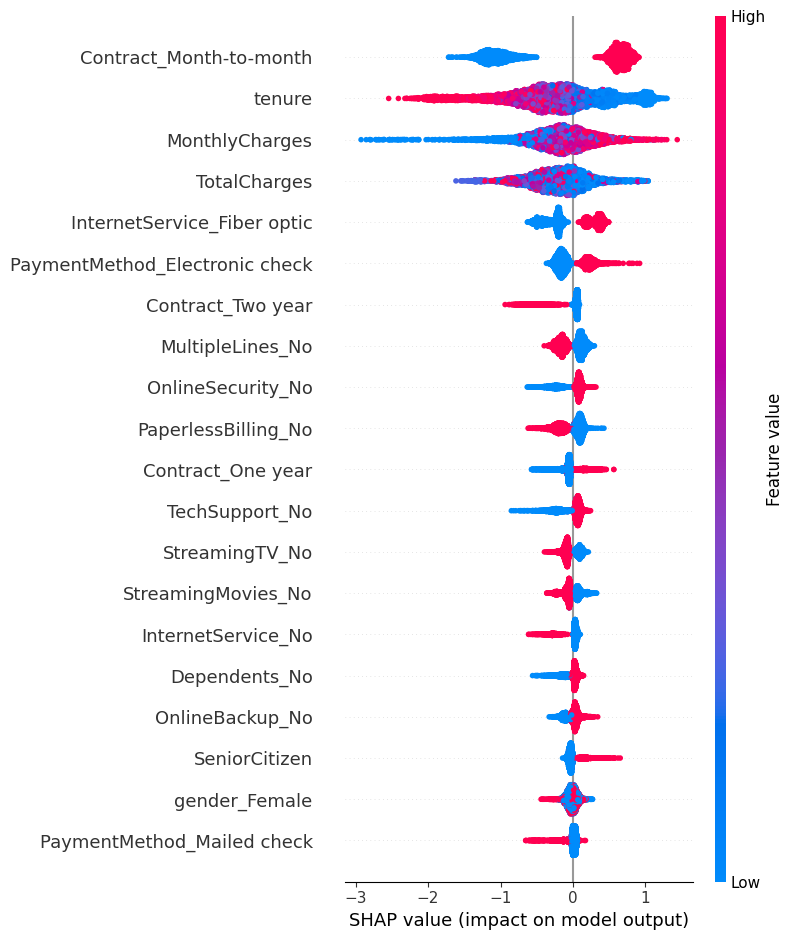

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_auc_score
)
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import shap

# =========================================================
# 0. LOAD DATA
# =========================================================
df = pd.read_csv(r"E:\Future Interns\WA_Fn-UseC_-Telco-Customer-Churn.csv")

# Target
y = df["Churn"].map({"Yes": 1, "No": 0})

# Features
X = df.drop(columns=["customerID", "Churn"])

# =========================================================
# 1. FIX MIXED TYPES
# =========================================================
internet_cols = [
    "OnlineSecurity", "OnlineBackup", "DeviceProtection",
    "TechSupport", "StreamingTV", "StreamingMovies"
]

# Replace "No internet service" with "No"
for col in internet_cols:
    X[col] = X[col].replace("No internet service", "No")

# Ensure numeric columns are floats
num_cols = ["SeniorCitizen","tenure","MonthlyCharges","TotalCharges"]
for col in num_cols:
    X[col] = pd.to_numeric(X[col], errors="coerce").fillna(0).astype(float)

# Ensure all other columns are categorical strings
cat_cols = [c for c in X.columns if c not in num_cols]
for col in cat_cols:
    X[col] = X[col].astype(str)

# =========================================================
# 2. TRAIN / TEST SPLIT
# =========================================================
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# =========================================================
# 3. PREPROCESSOR
# =========================================================
preprocessor = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore", sparse_output=False), cat_cols),
        ("num", "passthrough", num_cols),
    ]
)

# =========================================================
# 4. MODEL
# =========================================================
model = XGBClassifier(
    n_estimators=400,
    learning_rate=0.05,
    max_depth=5,
    subsample=0.9,
    colsample_bytree=0.9,
    eval_metric="logloss",
    scale_pos_weight=float(len(y_train[y_train==0]))/len(y_train[y_train==1]),
    random_state=42
)

# =========================================================
# 5. PIPELINE
# =========================================================
pipe = Pipeline(steps=[
    ("prep", preprocessor),
    ("clf", model)
])

# =========================================================
# 6. TRAIN
# =========================================================
pipe.fit(X_train, y_train)

# =========================================================
# 7. PREDICT
# =========================================================
y_prob = pipe.predict_proba(X_test)[:,1]
threshold = 0.35
y_pred = (y_prob >= threshold).astype(int)

# =========================================================
# 8. METRICS
# =========================================================
print("\nClassification Report\n")
print(classification_report(y_test, y_pred))
auc = roc_auc_score(y_test, y_prob)
print(f"ROC-AUC: {auc:.4f}")

# =========================================================
# 9. CONFUSION MATRIX
# =========================================================
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues")
plt.title("Confusion Matrix")
plt.ylabel("Actual")
plt.xlabel("Predicted")
plt.show()

# =========================================================
# 10. SHAP FEATURE NAMES
# =========================================================
ohe = pipe.named_steps["prep"].named_transformers_["cat"]
cat_features = ohe.get_feature_names_out(cat_cols)
feature_names = np.concatenate([cat_features, num_cols])

# =========================================================
# 11. TRANSFORM DATA
# =========================================================
X_train_trans = pipe.named_steps["prep"].transform(X_train)

# =========================================================
# 12. SHAP EXPLAINER
# =========================================================
explainer = shap.TreeExplainer(pipe.named_steps["clf"])
shap_values = explainer.shap_values(X_train_trans)

# =========================================================
# 13. SHAP SUMMARY PLOT
# =========================================================
shap.summary_plot(shap_values, X_train_trans, feature_names=feature_names)


In [2]:
import joblib

joblib.dump(pipe, "model.pkl")
print("Model saved as model.pkl")

Model saved as model.pkl
